In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, SimpleRNN
from nltk.tokenize import word_tokenize

In [2]:
# Read the Excel file into a pandas DataFrame
df = pd.read_csv('Dataset/Text_Emotion_Data.csv')


def RemoveStops(text, stop_words):
    # Remove special characters and lowercase the text
    text = re.sub(r"[^\w\s]", "", text.lower())
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

def ThreeDim_one_hot_encoder(dataset, dictionary):
    max_length = dataset.shape[1]
    vocab_size = max(dictionary.values()) + 1

    one_hot_word_array = np.zeros((dataset.shape[0], max_length, vocab_size))

    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            word = dataset[i, j]
            if word != '':
                if word in dictionary:
                    index = dictionary[word]
                    one_hot_word_array[i, j, index] = 1
                else:
                    # Handle unknown words (not present in the dictionary)
                    one_hot_word_array[i, j, 0] = 1

    return one_hot_word_array



# Remove non-letter characters from the 'Text' column
# df['Text'] = df['Text'].str.replace(r'[^a-zA-Z]', '', regex=True)
df['Text'] = df['Text'].str.replace(r'[^a-zA-Z\s]', '',regex=False)

# Remove short words (with length ≤ 2) from the 'Text' column
df['Text'] = df['Text'].str.split().apply(lambda x: ' '.join([word for word in x if len(word) > 2]))




# Read the stopwords from the file
stopwords = set(open('Dataset/stopwords.txt', 'r').read().split())
df['Text'] = df['Text'].apply(lambda x: RemoveStops(x, stopwords))



# Tokenize the 'Text' column
df['Tokenized_Text'] = df['Text'].apply(word_tokenize)


# Convert word sequences to integer sequences
integer_sequences = []

# Tokenize the text and add padding
for sequence in df['Tokenized_Text']:
    # Add the tokenized words to the integer sequences
    integer_sequence = [word.lower() for word in sequence if word.lower() not in stopwords]
    integer_sequences.append(integer_sequence)

# Determine the maximum sequence length
max_length = max(len(sequence) for sequence in integer_sequences)

# Pad the sequences with zeros to have the same length
padded_sequences = []
for sequence in integer_sequences:
    # Check if padding is needed
    if len(sequence) < max_length:
        # Calculate the number of padding tokens needed
        num_padding = max_length - len(sequence)
        
        # Add padding tokens (zeros) to the sequence
        padded_sequence = sequence + [0] * num_padding
    else:
        # No padding needed
        padded_sequence = sequence
    
    padded_sequences.append(padded_sequence)

# Add the padded sequences as a new column in the DataFrame
df['Padded_Text'] = padded_sequences





print(max_length)
df

19


,Text,Label,Tokenized_Text,Padded_Text
0,feel like finally position decide whether indu...,joy,"[feel, like, finally, position, decide, whethe...","[feel, like, finally, position, decide, whethe..."
1,feel resigned lot life watch everyone else bec...,sadness,"[feel, resigned, lot, life, watch, everyone, e...","[feel, resigned, lot, life, watch, everyone, e..."
2,feel thrilled presence eyes feel belief peace ...,joy,"[feel, thrilled, presence, eyes, feel, belief,...","[feel, thrilled, presence, eyes, feel, belief,..."
3,finally sit feel sweet release notice misplace...,joy,"[finally, sit, feel, sweet, release, notice, m...","[finally, sit, feel, sweet, release, notice, m..."
4,feel bit jealous trying date long time ago doe...,anger,"[feel, bit, jealous, trying, date, long, time,...","[feel, bit, jealous, trying, date, long, time,..."
...,...,...,...,...
3245,want say things want say without feeling embar...,sadness,"[want, say, things, want, say, without, feelin...","[want, say, things, want, say, without, feelin..."
3246,feel need generous offerings especially huntin...,love,"[feel, need, generous, offerings, especially, ...","[feel, need, generous, offerings, especially, ..."
3247,sitting belmont library listening hold tight e...,sadness,"[sitting, belmont, library, listening, hold, t...","[sitting, belmont, library, listening, hold, t..."
3248,let sad feeling want accepted first home mine,love,"[let, sad, feeling, want, accepted, first, hom...","[let, sad, feeling, want, accepted, first, hom..."


In [3]:
# Get all the unique words from your dataset
unique_words = []
for sequence in df['Padded_Text']:
    unique_words.extend(sequence)

# Remove duplicates and sort the unique words
unique_words = sorted(set(map(str, unique_words)))

# Create a dictionary of unique words
word_dictionary = {word: index for index, word in enumerate(unique_words)}

# Print the number of unique words
print("Number of Unique Words:", len(unique_words))

# Print the word dictionary
print("Word Dictionary:")
print(len(word_dictionary))


Number of Unique Words: 6523
Word Dictionary:
6523


In [21]:
X = np.array(df['Padded_Text'].tolist())
# Define the labels
labels = df['Label'].values
classes = np.unique(labels)
label_map = {label: i for i, label in enumerate(classes)}
y = np.array([label_map[label] for label in labels])

# Split last 150 text of each class for the test dataset
test_data = []
for c in classes:
    class_data = [(X[i], y[i]) for i in range(len(X)) if y[i] == label_map[c]]
    test_data.extend(class_data[-150:])

# Use the rest of the data for training
train_data = []
for i in range(len(X)):
    found = False
    for j in range(len(test_data)):
        if all(X[i] == test_data[j][0]) and y[i] == test_data[j][1]:
            found = True
            break
    if not found:
        train_data.append((X[i], y[i]))

# Separate the input features and labels for the training and test sets
X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)


X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [22]:
print('shape of X_train',X_train.shape)
print('shape of y_train',y_train.shape)
print('shape of X_test',X_test.shape)
print('shape of y_test',y_test.shape)

shape of X_train (2500, 19)
shape of y_train (2500,)
shape of X_test (750, 19)
shape of y_test (750,)


In [23]:
X_train = ThreeDim_one_hot_encoder(X_train ,word_dictionary )
X_test = ThreeDim_one_hot_encoder(X_test ,word_dictionary )
print('shape of X_train',X_train.shape)
print('shape of y_train',y_train.shape)
print('shape of X_test',X_test.shape)
print('shape of y_test',y_test.shape)


shape of X_train (2500, 19, 6523)
shape of y_train (2500,)
shape of X_test (750, 19, 6523)
shape of y_test (750,)


array([2, 4, 2, ..., 4, 3, 1])

In [24]:
# Define the model architecture
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=len(classes), activation='softmax'))
# model.add(Dense(64, activation='relu', input_dim=vocab_size))


# Compile the model
# optimizer = optimizers.Adam(learning_rate=0.01)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on train and test data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
79/79 [==============================] - 4s 46ms/step - loss: 1.5603 - accuracy: 0.2788 - val_loss: 1.3557 - val_accuracy: 0.4120
Epoch 2/10
79/79 [==============================] - 3s 34ms/step - loss: 0.7440 - accuracy: 0.7672 - val_loss: 1.2161 - val_accuracy: 0.5280
Epoch 3/10
79/79 [==============================] - 3s 37ms/step - loss: 0.2090 - accuracy: 0.9580 - val_loss: 1.4554 - val_accuracy: 0.5067
Epoch 4/10
79/79 [==============================] - 3s 38ms/step - loss: 0.0532 - accuracy: 0.9944 - val_loss: 1.4866 - val_accuracy: 0.5573
Epoch 5/10
79/79 [==============================] - 3s 34ms/step - loss: 0.0203 - accuracy: 0.9980 - val_loss: 1.5760 - val_accuracy: 0.5453
Epoch 6/10
79/79 [==============================] - 3s 35ms/step - loss: 0.0094 - accuracy: 0.9996 - val_loss: 1.6744 - val_accuracy: 0.5600
Epoch 7/10
79/79 [==============================] - 3s 34ms/step - loss: 0.0063 - accuracy: 0.9996 - val_loss: 1.7527 - val_accuracy: 0.5520
Epoch 8/10
79

24/24 [==============================] - 0s 10ms/step
Train Accuracy: 0.9996
Test Accuracy: 0.47333333333333333
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

Test Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       150
           1       0.47      0.56      0.51       150
           2       0.35      0.27      0.31       150
           3       0.51      0.50      0.51       150
           4       0.45      0.49      0.47       150

    accuracy    

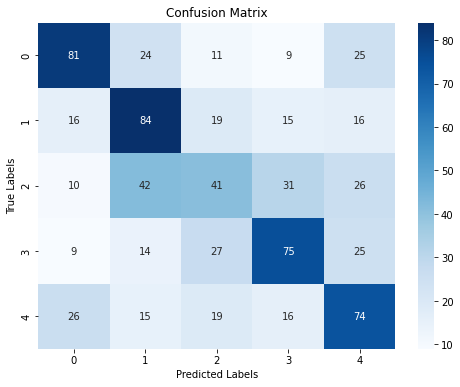

In [18]:

# Get predicted labels
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions to class labels
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_labels)
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Generate classification report for train data
train_report = classification_report(y_train, y_train_pred_labels)
print("Train Classification Report:")
print(train_report)

# Generate classification report for test data
test_report = classification_report(y_test, y_test_pred_labels)
print("Test Classification Report:")
print(test_report)

# Calculate confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()